In [1]:
# Author: Arthur Prigent
# Email: aprigent@ictp.it

In [2]:
from load_librairies import *
from scipy.stats.stats import pearsonr
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches


def nandetrend(y):
    ''' Remove the linear trend from the data '''
    
    x = np.arange(0,y.shape[0],1)
    m, b, r_val, p_val, std_err = stats.linregress(x,np.array(y))
    y_detrended= np.array(y) - m*x
    return y_detrended


def is_jja(month):
    return (month>=6) & (month<=8)


def is_f(month):
    return (month==2)
def is_mar(month):
    return (month==3)

def is_apr(month):
    return (month==4)

def is_may(month):
    return (month==5)

def is_amj(month):
    return (month>=4) & (month<=6)


dir_proj = '/home/netapp-clima-users/users/aprigent/Projects/TAV_OMIP/'
path_fig = dir_proj+'/figures_final/'

dir_forcing = '/home/clima-archive2/rfarneti/INPUT_DATA/JRA55-do-1-5-0/'
dir_tos_omip1 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/'
dir_tos_omip2 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/'
#dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/HadI-SST/'
dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/'
path_data_out = '/media/aprigent/Arthur_disk/data_uncertainty/'
dir_ccmp = '/media/aprigent/Arthur_disk/TAV_OMIP/'

period_str = 1985
period_end = 2004

%matplotlib inline

/tmp/ipykernel_20297/1042716884.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [3]:
omip1_models = pd.read_csv(dir_proj+'/scripts/omip1_models_for_BF_zos.txt',header=None,delimiter=',')
omip1_models = omip1_models[0].values.tolist()
print(omip1_models)


omip2_models = pd.read_csv(dir_proj+'/scripts/omip2_models_for_BF_zos.txt',header=None,delimiter=',')
omip2_models = omip2_models[0].values.tolist()
print(omip2_models)

['CMCC-CM2-SR5', 'CMCC-ESM2', 'EC-Earth3', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'NorESM2-LM']
['ACCESS-OM2', 'ACCESS-OM2-025', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'EC-Earth3', 'MRI-ESM2-0', 'NorESM2-LM']


# Load JRA-55 and CORE2 wind data

In [4]:
uas_jra55_atl_mon = xr.open_dataset('/media/aprigent/Arthur_disk/Data/MOM_JRA55do/JRA_uas.1958_2022_atl_monmean.nc',
                            use_cftime=True)

uas_jra55_atl_mon = uas_jra55_atl_mon.sel(time=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))

In [5]:
uas_jra55_atl_arr = np.array(uas_jra55_atl_mon.uas)
uas_jra55_atl_dtd = np.ones((uas_jra55_atl_mon.uas.shape))*np.nan
for i in range(uas_jra55_atl_dtd.shape[1]):
    for j in range(uas_jra55_atl_dtd.shape[2]):
        uas_jra55_atl_dtd[:,i,j] = nandetrend(uas_jra55_atl_arr[:,i,j])

        
uas_jra55_atl_dataset = xr.Dataset({'uas_dtd': (['time','lat','lon'], uas_jra55_atl_dtd), 
    }, 
    coords={'time': np.array(uas_jra55_atl_mon.time), 
    'lat': np.array(uas_jra55_atl_mon.lat), 
    'lon': np.array(uas_jra55_atl_mon.lon)} ) 



uas_jra55_atl_dataset_monthly = uas_jra55_atl_dataset.sel(time=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))

In [6]:
uasa_jra55_atl_dataset_monthly,_ = Atools.ano_norm_t(uas_jra55_atl_dataset_monthly.uas_dtd)


uasa_jra55_atl_dataset_amj = uasa_jra55_atl_dataset_monthly.sel(time=is_amj(
    uasa_jra55_atl_dataset_monthly['time.month'])).groupby('time.year').mean()

std_uasa_jra55_atl_dataset_amj = uasa_jra55_atl_dataset_amj.std(dim='year')

## CORE-II

In [7]:

uas_core2_atl_mon = xr.open_dataset('/media/aprigent/Arthur_disk/Data/CORE2/u_10_mod.1948-2007.paddednomads_atl_monmean.nc',
                            use_cftime=True)
uas_core2_atl_mon['TIME'] = uas_core2_atl_mon.indexes['TIME'].to_datetimeindex()

uas_core2_atl_mon = uas_core2_atl_mon.sel(TIME=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))

/tmp/ipykernel_20297/2400160151.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  uas_core2_atl_mon['TIME'] = uas_core2_atl_mon.indexes['TIME'].to_datetimeindex()


In [8]:
uas_core2_atl_arr = np.array(uas_core2_atl_mon.U_10_MOD)
uas_core2_atl_dtd = np.ones((uas_core2_atl_mon.U_10_MOD.shape))*np.nan
for i in range(uas_core2_atl_dtd.shape[1]):
    for j in range(uas_core2_atl_dtd.shape[2]):
        uas_core2_atl_dtd[:,i,j] = nandetrend(uas_core2_atl_arr[:,i,j])

        
uas_core2_atl_dataset = xr.Dataset({'uas_dtd': (['time','lat','lon'], uas_core2_atl_dtd), 
    }, 
    coords={'time': np.array(uas_core2_atl_mon.TIME), 
    'lat': np.array(uas_core2_atl_mon.LAT), 
    'lon': np.array(uas_core2_atl_mon.LON)} ) 



uas_core2_atl_dataset_monthly = uas_core2_atl_dataset.sel(time=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))

In [9]:
uasa_core2_atl_dataset_monthly,_ = Atools.ano_norm_t(uas_core2_atl_dataset_monthly.uas_dtd)

In [10]:

uasa_core2_atl_dataset_amj = uasa_core2_atl_dataset_monthly.sel(time=is_amj(
    uasa_core2_atl_dataset_monthly['time.month'])).groupby('time.year').mean()

std_uasa_core2_atl_dataset_amj = uasa_core2_atl_dataset_amj.std(dim='year')

# Load ATL4 indexes
-TAV_OMIP/scripts/processing/prepare_data_for_figure_07_uas_JRA55_COREII.ipynb

In [11]:
core2_atl4_new = xr.open_dataset(path_data_out+'u10_core2_1985_2004_new.nc')
jra5_atl4_new = xr.open_dataset(path_data_out+'u10_jra55_1985_2004_new.nc')
era5_atl4_new = xr.open_dataset(path_data_out+'u10_era5_1985_2004_new.nc')
ncep2_atl4_new = xr.open_dataset(path_data_out+'u10_ncep2_1985_2004_new.nc')
ncep_atl4_new = xr.open_dataset(path_data_out+'u10_ncep_1985_2004_new.nc')

## check ATL4-averaged UASa  timeseries

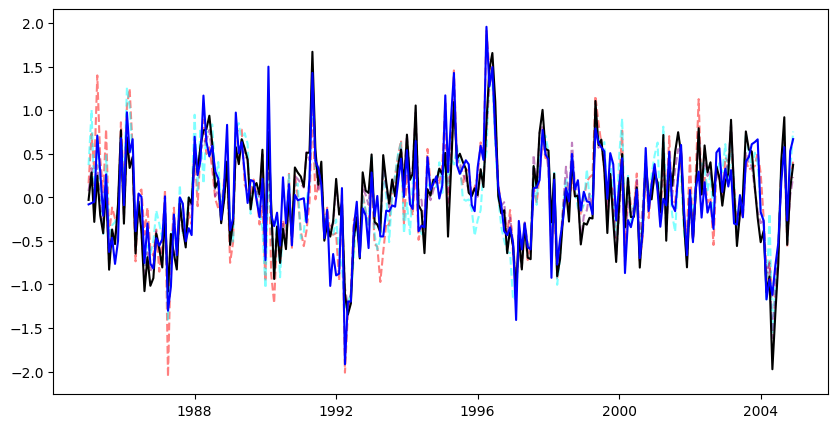

In [12]:
f,ax = plt.subplots(1,1,figsize=[10,5])


ax.plot(era5_atl4_new.time,era5_atl4_new.uasa,color='red',linestyle='--',alpha=0.5)
ax.plot(ncep2_atl4_new.time,ncep2_atl4_new.uasa,color='cyan',linestyle='--',alpha=0.5)
ax.plot(ncep_atl4_new.time,ncep_atl4_new.uasa,color='purple',linestyle='--',alpha=0.5)
ax.plot(core2_atl4_new.time,core2_atl4_new.uasa,color='black')
ax.plot(jra5_atl4_new.time,jra5_atl4_new.uasa,color='blue')

#ax.plot(ncep2_atl4.time,ncep2_atl4.uasa)
#ax.plot(ncep_atl4.time,ncep_atl4.uasa)

## CCMP

In [13]:
uwind_ccmp = xr.open_dataset(dir_ccmp+'ccmp_uwind_r360x180.nc')

uwind_ccmp = uwind_ccmp.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))

uwind_ccmp = xr.concat([uwind_ccmp.uwnd[:,:,180:],uwind_ccmp.uwnd[:,:,:180]],dim = 'lon') 
uwind_ccmp.coords['lon'] = (uwind_ccmp.coords['lon'] + 180)%360 - 180


uwind_ccmp = uwind_ccmp.sel(time=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))
uwind_ccmp = Atools.data_sub(uwind_ccmp,-40,-20,-3,3)
uwind_ccmp_arr = np.array(uwind_ccmp)
uwind_ccmp_arr_dtd = np.ones((uwind_ccmp_arr.shape))*np.nan
for i in range(uwind_ccmp_arr_dtd.shape[1]):
    for j in range(uwind_ccmp_arr_dtd.shape[2]):
        uwind_ccmp_arr_dtd[:,i,j] = nandetrend(uwind_ccmp_arr[:,i,j])

        
uwind_ccmp_atl_dataset = xr.Dataset({'uas_dtd': (['time','lat','lon'], uwind_ccmp_arr_dtd), 
    }, 
    coords={'time': np.array(uwind_ccmp.time), 
    'lat': np.array(uwind_ccmp.lat), 
    'lon': np.array(uwind_ccmp.lon)} ) 



uwind_ccmp_atl_dataset_monthly = uwind_ccmp_atl_dataset.sel(time=slice(datetime(period_str, 1, 1),
                                                               datetime(period_end, 12, 31)))






In [14]:
uwinda_ccmp_atl4_dtd,_ = Atools.ano_norm_t(uwind_ccmp_atl_dataset_monthly.uas_dtd)

In [15]:
uwinda_ccmp_atl4_dtd_mean = uwinda_ccmp_atl4_dtd.weighted(
        np.cos(np.deg2rad(uwinda_ccmp_atl4_dtd.lat))).mean(('lon','lat'))


uwind_ccmp_atl_dataset_monthly_atl4_mean = uwind_ccmp_atl_dataset_monthly.weighted(
        np.cos(np.deg2rad(uwind_ccmp_atl_dataset_monthly.lat))).mean(('lon','lat'))

In [16]:

clim_uwind_ccmp_atl4 = uwind_ccmp_atl_dataset_monthly_atl4_mean.uas_dtd.groupby('time.month').mean()



In [17]:
std_uwinda_ccmp_atl4_dtd = uwinda_ccmp_atl4_dtd_mean.groupby('time.month').std()

# check february weird peak

In [18]:
core2_atl4_new_feb = core2_atl4_new.sel(time=is_f(core2_atl4_new['time.month']))
jra5_atl4_new_feb = jra5_atl4_new.sel(time=is_f(jra5_atl4_new['time.month']))
era5_atl4_new_feb = era5_atl4_new.sel(time=is_f(era5_atl4_new['time.month']))
ncep2_atl4_new_feb = ncep2_atl4_new.sel(time=is_f(ncep2_atl4_new['time.month']))
ccmp_atl4_new_feb = uwinda_ccmp_atl4_dtd_mean.sel(time=is_f(uwinda_ccmp_atl4_dtd_mean['time.month']))

In [19]:
core2_atl4_new_mar = core2_atl4_new.sel(time=is_mar(core2_atl4_new['time.month']))
jra5_atl4_new_mar = jra5_atl4_new.sel(time=is_mar(jra5_atl4_new['time.month']))
era5_atl4_new_mar = era5_atl4_new.sel(time=is_mar(era5_atl4_new['time.month']))
ncep2_atl4_new_mar = ncep2_atl4_new.sel(time=is_mar(ncep2_atl4_new['time.month']))
ccmp_atl4_new_mar = uwinda_ccmp_atl4_dtd_mean.sel(time=is_mar(uwinda_ccmp_atl4_dtd_mean['time.month']))

In [20]:
core2_atl4_new_apr = core2_atl4_new.sel(time=is_apr(core2_atl4_new['time.month']))
jra5_atl4_new_apr = jra5_atl4_new.sel(time=is_apr(jra5_atl4_new['time.month']))
era5_atl4_new_apr = era5_atl4_new.sel(time=is_apr(era5_atl4_new['time.month']))
ncep2_atl4_new_apr = ncep2_atl4_new.sel(time=is_apr(ncep2_atl4_new['time.month']))
ccmp_atl4_new_apr = uwinda_ccmp_atl4_dtd_mean.sel(time=is_apr(uwinda_ccmp_atl4_dtd_mean['time.month']))

In [21]:
core2_atl4_new_may = core2_atl4_new.sel(time=is_may(core2_atl4_new['time.month']))
jra5_atl4_new_may = jra5_atl4_new.sel(time=is_may(jra5_atl4_new['time.month']))
era5_atl4_new_may = era5_atl4_new.sel(time=is_may(era5_atl4_new['time.month']))
ncep2_atl4_new_may = ncep2_atl4_new.sel(time=is_may(ncep2_atl4_new['time.month']))
ccmp_atl4_new_may = uwinda_ccmp_atl4_dtd_mean.sel(time=is_may(uwinda_ccmp_atl4_dtd_mean['time.month']))

In [22]:
years = np.arange(1985.5,2005.5,1)

# Figure S9

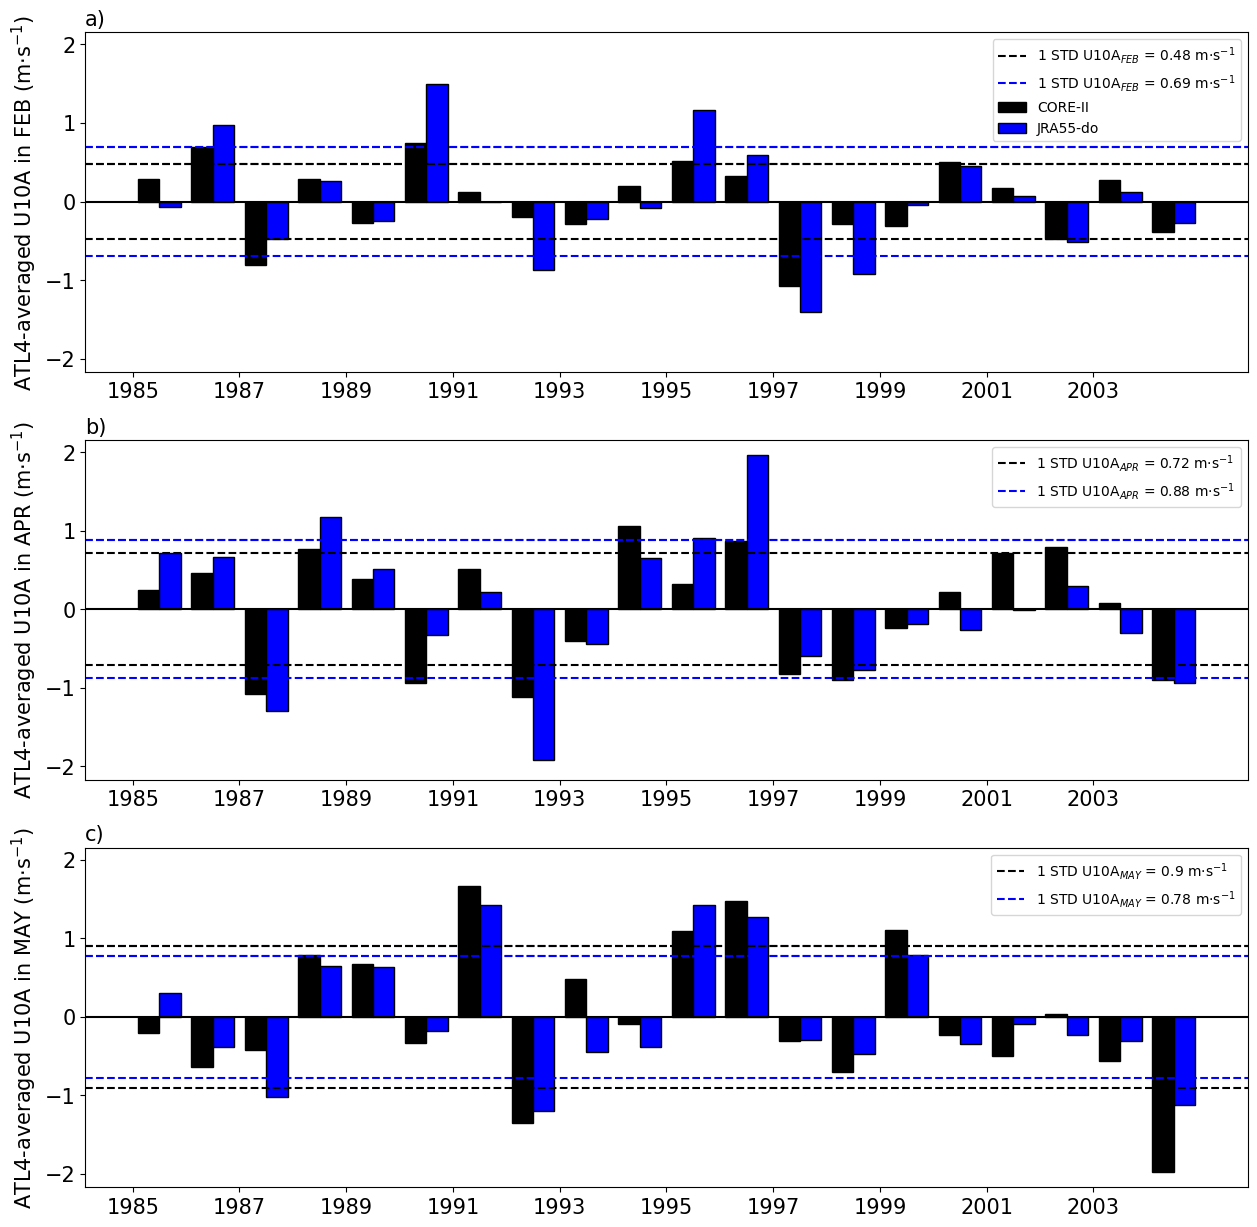

In [23]:
f,ax = plt.subplots(3,1,figsize=[15,15],sharey=True)
ax=ax.ravel()
ftz=15
ax[0].bar(years-0.4,core2_atl4_new_feb.uasa.values,
          width=0.4,color='black',align='edge',label='CORE-II',edgecolor='black')
ax[0].bar(years,jra5_atl4_new_feb.uasa,
          width=0.4,color='blue',align='edge',label='JRA55-do',edgecolor='black')

ax[0].axhline(core2_atl4_new_feb.uasa.std(),color='black',linestyle='--')
ax[0].axhline(-core2_atl4_new_feb.uasa.std(),color='black',linestyle='--')
ax[0].axhline(jra5_atl4_new_feb.uasa.std(),color='blue',linestyle='--')
ax[0].axhline(-jra5_atl4_new_feb.uasa.std(),color='blue',linestyle='--')
ax[0].axhline(core2_atl4_new_feb.uasa.std(),
              color='black',linestyle='--',
              label='1 STD U10A$_{FEB}$ = '+
              str(np.round(core2_atl4_new_feb.uasa.std().values,2))+' m$\cdot$s$^{-1}$')

ax[0].axhline(jra5_atl4_new_feb.uasa.std(),
              color='blue',linestyle='--',
              label='1 STD U10A$_{FEB}$ = '+
              str(np.round(jra5_atl4_new_feb.uasa.std().values,2))+' m$\cdot$s$^{-1}$')
ax[0].axhline(0,color='black')
ax[0].legend(fontsize=ftz-5)
ax[0].set_xticks(np.arange(1985,2005,2))
ax[0].set_ylabel('ATL4-averaged U10A in FEB (m$\cdot$s$^{-1}$)',fontsize=ftz)
ax[0].tick_params(labelsize=ftz)


ax[1].bar(years-0.4,core2_atl4_new_apr.uasa.values,width=0.4,color='black',align='edge',edgecolor='black')
ax[1].bar(years,jra5_atl4_new_apr.uasa,width=0.4,color='blue',align='edge',edgecolor='black')

ax[1].axhline(0,color='black')
ax[1].set_xticks(np.arange(1985,2005,2))
ax[1].set_ylabel('ATL4-averaged U10A in APR (m$\cdot$s$^{-1}$)',fontsize=ftz)
ax[1].tick_params(labelsize=ftz)
ax[1].axhline(core2_atl4_new_apr.uasa.std(),
              color='black',linestyle='--',
              label='1 STD U10A$_{APR}$ = '+
              str(np.round(core2_atl4_new_apr.uasa.std().values,2))+' m$\cdot$s$^{-1}$')

ax[1].axhline(jra5_atl4_new_apr.uasa.std(),
              color='blue',linestyle='--',
              label='1 STD U10A$_{APR}$ = '+
              str(np.round(jra5_atl4_new_apr.uasa.std().values,2))+' m$\cdot$s$^{-1}$')

ax[1].axhline(-core2_atl4_new_apr.uasa.std(),color='black',linestyle='--')
ax[1].axhline(jra5_atl4_new_apr.uasa.std(),color='blue',linestyle='--')
ax[1].axhline(-jra5_atl4_new_apr.uasa.std(),color='blue',linestyle='--')
ax[1].legend(fontsize=ftz-5)


ax[2].bar(years-0.4,core2_atl4_new_may.uasa.values,width=0.4,color='black',align='edge',edgecolor='black')
ax[2].bar(years,jra5_atl4_new_may.uasa.values,width=0.4,color='blue',align='edge',edgecolor='black')
ax[2].axhline(0,color='black')
ax[2].set_xticks(np.arange(1985,2005,2))
ax[2].set_ylabel('ATL4-averaged U10A in MAY (m$\cdot$s$^{-1}$)',fontsize=ftz)
ax[2].tick_params(labelsize=ftz)
ax[2].axhline(core2_atl4_new_may.uasa.std(),color='black',linestyle='--')
ax[2].axhline(-core2_atl4_new_may.uasa.std(),color='black',linestyle='--')

ax[2].axhline(jra5_atl4_new_may.uasa.std(),color='blue',linestyle='--')
ax[2].axhline(-jra5_atl4_new_may.uasa.std(),color='blue',linestyle='--')
ax[2].axhline(core2_atl4_new_may.uasa.std(),
              color='black',linestyle='--',
              label='1 STD U10A$_{MAY}$ = '+
              str(np.round(core2_atl4_new_may.uasa.std().values,2))+' m$\cdot$s$^{-1}$')

ax[2].axhline(jra5_atl4_new_may.uasa.std(),
              color='blue',linestyle='--',
              label='1 STD U10A$_{MAY}$ = '+
              str(np.round(jra5_atl4_new_may.uasa.std().values,2))+' m$\cdot$s$^{-1}$')
ax[2].legend(fontsize=ftz-5)

ax[0].text(0,1.02,'a)',transform=ax[0].transAxes,size=ftz)
ax[1].text(0,1.02,'b)',transform=ax[1].transAxes,size=ftz)
ax[2].text(0,1.02,'c)',transform=ax[2].transAxes,size=ftz)
plt.savefig(path_fig+'figure_S09.png',bbox_inches='tight',dpi=300)